# Projet : Détection de fraude bancaire

**Auteur :** Mohamed Lamine OULD BOUYA  
**Objectif :** Construire un classifieur capable de détecter des transactions frauduleuses avec un **haut rappel** et une **bonne précision-rappel** (PR-AUC) malgré un **déséquilibre extrême** entre les données de transactions normales et les fraudes.

- Dataset : [Kaggle - Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)  
- Stack : Python, pandas, scikit-learn, imbalanced-learn, RandomForest, XGBoost
- Métriques : **PR-AUC (Average Precision)**, **ROC-AUC**, **rappel**, **précision**, **F1** (+ matrice de confusion)  
- Validations : split **stratifié** (80/20) + **CV stratifiée** pour le tuning

## 1-) Imports et configuration

In [56]:
import os, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve,
    classification_report, confusion_matrix
)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import xgboost as xgb

plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.grid"] = True

def summarize_metrics(y_true, proba, threshold=0.5):
    ap  = average_precision_score(y_true, proba)
    roc = roc_auc_score(y_true, proba)
    pred = (proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, pred)
    rep = classification_report(y_true, pred, output_dict=True, zero_division=0)
    return {
        "pr_auc": float(ap),
        "roc_auc": float(roc),
        "threshold": float(threshold),
        "precision": rep["1"]["precision"],
        "recall": rep["1"]["recall"],
        "f1": rep["1"]["f1-score"],
        "confusion_matrix": cm.tolist()
    }

def optimal_threshold_by_fbeta(y_true, proba, beta=2.0):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    fbeta = (1+beta**2) * (prec*rec) / np.maximum((beta**2)*prec + rec, 1e-12)
    idx = np.nanargmax(fbeta)
    thr_opt = thr[idx-1] if idx == len(thr) else thr[idx]
    return float(thr_opt), (prec, rec, thr, fbeta, idx)

def plot_pr_curves(curves, title="Precision–Recall curves"):
    plt.figure()
    for label, prec, rec, ap, point in curves:
        plt.plot(rec, prec, label=f"{label} (AP={ap:.3f})")
        if point is not None:
            r, p = point
            plt.scatter([r],[p], marker='o')
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(title)
    plt.legend(loc='best'); plt.show()

def plot_roc_curves(curves, title="ROC curves"):
    plt.figure()
    for label, fpr, tpr, roc in curves:
        plt.plot(fpr, tpr, label=f"{label} (AUC={roc:.3f})")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(title)
    plt.legend(loc='best'); plt.show()

## 2-) Chargement des données et typage mémoire

In [57]:
df = pd.read_csv(r"C:\Users\ouldb\Documents\projet-fraude\creditcard.csv")

# Conversion légère des types de données pour réduire la consommation mémoire
num_cols = [c for c in df.columns if c != "Class"]
df[num_cols] = df[num_cols].astype("float32")
df["Class"] = df["Class"].astype("int8")

print(df.shape)
print("Fraude proportion:", df["Class"].mean())
df.head()

(284807, 31)
Fraude proportion: 0.001727485630620034


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.619995,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660004,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798279,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.989998,0


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float32
 1   V1      284807 non-null  float32
 2   V2      284807 non-null  float32
 3   V3      284807 non-null  float32
 4   V4      284807 non-null  float32
 5   V5      284807 non-null  float32
 6   V6      284807 non-null  float32
 7   V7      284807 non-null  float32
 8   V8      284807 non-null  float32
 9   V9      284807 non-null  float32
 10  V10     284807 non-null  float32
 11  V11     284807 non-null  float32
 12  V12     284807 non-null  float32
 13  V13     284807 non-null  float32
 14  V14     284807 non-null  float32
 15  V15     284807 non-null  float32
 16  V16     284807 non-null  float32
 17  V17     284807 non-null  float32
 18  V18     284807 non-null  float32
 19  V19     284807 non-null  float32
 20  V20     284807 non-null  float32
 21  V21     28

## 3-) Analyse Exploratoire des Données (EDA)

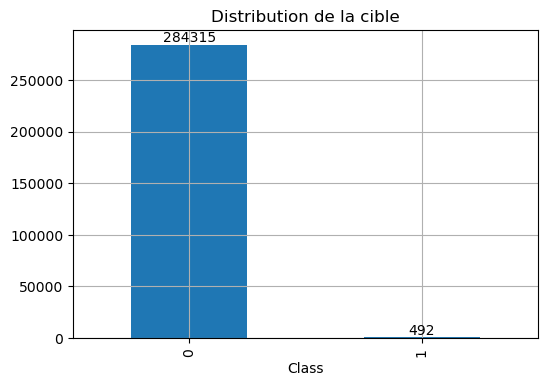

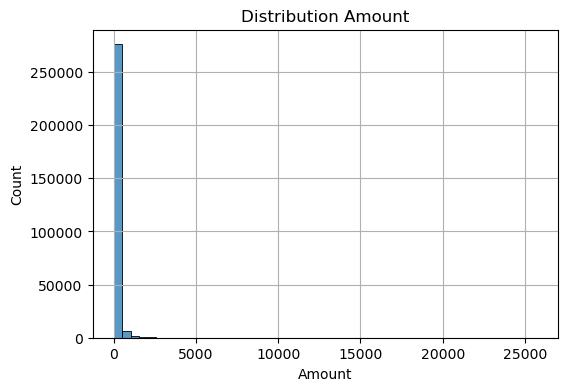

In [59]:
# Distribution de la cible
ax = df["Class"].value_counts().plot(kind="bar", title="Distribution de la cible")
ax.bar_label(ax.containers[0], fmt="%d"); plt.show()

# Distribution du montant
sns.histplot(df["Amount"], bins=50)
plt.title("Distribution Amount"); plt.show()

## 4-) Split stratifié 80/20 (train/test)

In [60]:
X = df.drop(columns=["Class"]) ; y = df["Class"]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for tr, te in sss.split(X, y):
    X_train, X_test = X.iloc[tr], X.iloc[te]
    y_train, y_test = y.iloc[tr], y.iloc[te]
X_train.shape, y_train.mean(), y_test.mean()

((227845, 30), 0.001729245759178389, 0.0017204452090867595)

## 5-) Modèle de train sur les données brutes sans optimisation

In [61]:
# Baseline: StandardScaler + LogisticRegression (aucun tuning, aucun rééchantillonnage)
baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, solver="lbfgs"))
])
baseline.fit(X_train, y_train)

# Probas train/test
p_train = baseline.predict_proba(X_train)[:,1]
p_test  = baseline.predict_proba(X_test)[:,1]

# Erreur/fonction optimisée par le modèle (information)
print("La RL (lbfgs) optimise la log-loss (NLL) via un algorithme quasi-Newton.")

# Seuil par défaut (0.5) sur train
m_train_default = summarize_metrics(y_train, p_train, threshold=0.5)
m_train_default

La RL (lbfgs) optimise la log-loss (NLL) via un algorithme quasi-Newton.


{'pr_auc': 0.7729636587472233,
 'roc_auc': 0.9826353071594803,
 'threshold': 0.5,
 'precision': 0.8861209964412812,
 'recall': 0.631979695431472,
 'f1': 0.7377777777777778,
 'confusion_matrix': [[227419, 32], [145, 249]]}

### 5.1-) Seuil optimisé (F-β, β=2) - Train

In [62]:
thr_opt_train, (prec_tr, rec_tr, thr_tr, fbeta_tr, idx_tr) = optimal_threshold_by_fbeta(y_train, p_train, beta=2.0)
m_train_opt = summarize_metrics(y_train, p_train, threshold=thr_opt_train)
print("Seuil optimal (train, Fβ=2):", thr_opt_train)
m_train_opt

Seuil optimal (train, Fβ=2): 0.07690699397640012


{'pr_auc': 0.7729636587472233,
 'roc_auc': 0.9826353071594803,
 'threshold': 0.07690699397640012,
 'precision': 0.7964824120603015,
 'recall': 0.8045685279187818,
 'f1': 0.8005050505050505,
 'confusion_matrix': [[227370, 81], [77, 317]]}

## 6-) Modèle de train ptimisé avec GridSearch et SMOTE)

- **Pipeline** : `StandardScaler` -> `SMOTE` (***train only*** en CV) -> `LogisticRegression`
- **Grille** : `penalty ∈ {L1, L2}`, `C ∈ {0.1, 1, 10}` 
- **CV** : `StratifiedKFold(n_splits=5, shuffle=True, random_state=42)`
- **Critère de sélection** : `average_precision` (PR-AUC) **moyennée CV**

In [63]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(max_iter=2000, solver="liblinear"))  # liblinear supporte L1/L2
])

param_grid = {
    "clf__penalty": ["l1", "l2"],
    "clf__C": [0.1, 1, 10],
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid=param_grid, scoring="average_precision",
                    cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

grid.best_params_, grid.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


({'clf__C': 0.1, 'clf__penalty': 'l1'}, 0.7530516990814528)

### 6.1-) Évaluation train (seuil optimisé) et export des artefacts

In [64]:
best_lr = grid.best_estimator_
proba_train_lr = best_lr.predict_proba(X_train)[:,1]
thr_opt_lr, (prec_lr, rec_lr, thr_lr, fbeta_lr, idx_lr) = optimal_threshold_by_fbeta(y_train, proba_train_lr, beta=2.0)
metrics_train_lr = summarize_metrics(y_train, proba_train_lr, threshold=thr_opt_lr)
metrics_train_lr

{'pr_auc': 0.7474652274869984,
 'roc_auc': 0.9884694303656233,
 'threshold': 0.9997381230379375,
 'precision': 0.7418604651162791,
 'recall': 0.8096446700507615,
 'f1': 0.7742718446601942,
 'confusion_matrix': [[227340, 111], [75, 319]]}

## 7-) Évaluation sur Test - LR optimisée vs RandomForest vs XGBoost

- Entraînement de chaque modèle **sur tout le train** (avec ses hyperparams sélectionnés le cas échéant), puis évaluation sur **test**
- Pour chaque modèle : PR-AUC, ROC-AUC, seuil optimisé F-β (β=2), matrice de confusion, rapport de classification
- Construction des courbes PR/ROC comparatives

In [65]:
results = {}
pr_curves = []
roc_curves = []

def evaluate_model(label, fitted_estimator, X_test, y_test):
    proba = fitted_estimator.predict_proba(X_test)[:,1]
    ap = average_precision_score(y_test, proba)
    roc = roc_auc_score(y_test, proba)
    thr_opt, (prec, rec, thr, fbeta, idx) = optimal_threshold_by_fbeta(y_test, proba, beta=2.0)
    res = summarize_metrics(y_test, proba, threshold=thr_opt)
    results[label] = res

    # Courbes
    pr_curves.append((label, prec, rec, ap, (rec[idx], prec[idx])))
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_curves.append((label, fpr, tpr, roc))
    return res

# 7.1) LR optimisée (grid déjà fit -> best_lr)
res_lr = evaluate_model("LR + SMOTE (grid)", best_lr, X_test, y_test)

# 7.2) RandomForest
rf = RandomForestClassifier(
    n_estimators=300, max_depth=None,
    min_samples_split=2, min_samples_leaf=1,
    class_weight="balanced_subsample", random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)
res_rf = evaluate_model("RandomForest", rf, X_test, y_test)

# 7.3) XGBoost (toujours exécuté)
xgb_clf = xgb.XGBClassifier(
    n_estimators=300, max_depth=4, learning_rate=0.08,
    subsample=0.9, colsample_bytree=0.9,
    reg_lambda=1.0, objective="binary:logistic",
    eval_metric="aucpr", n_jobs=-1, random_state=42
)
xgb_clf.fit(X_train, y_train)
res_xgb = evaluate_model("XGBoost", xgb_clf, X_test, y_test)

results

{'LR + SMOTE (grid)': {'pr_auc': 0.7196815385296881,
  'roc_auc': 0.9707624098457616,
  'threshold': 0.9999976218848039,
  'precision': 0.7961165048543689,
  'recall': 0.8367346938775511,
  'f1': 0.8159203980099502,
  'confusion_matrix': [[56843, 21], [16, 82]]},
 'RandomForest': {'pr_auc': 0.8622748060998633,
  'roc_auc': 0.9514541677672756,
  'threshold': 0.17,
  'precision': 0.8349514563106796,
  'recall': 0.8775510204081632,
  'f1': 0.8557213930348259,
  'confusion_matrix': [[56847, 17], [12, 86]]},
 'XGBoost': {'pr_auc': 0.8746921222015075,
  'roc_auc': 0.9779613801063476,
  'threshold': 0.3833106458187103,
  'precision': 0.9325842696629213,
  'recall': 0.8469387755102041,
  'f1': 0.8877005347593583,
  'confusion_matrix': [[56858, 6], [15, 83]]}}

### 7.1-) Courbes comparatives (PR et ROC) - modèles de test

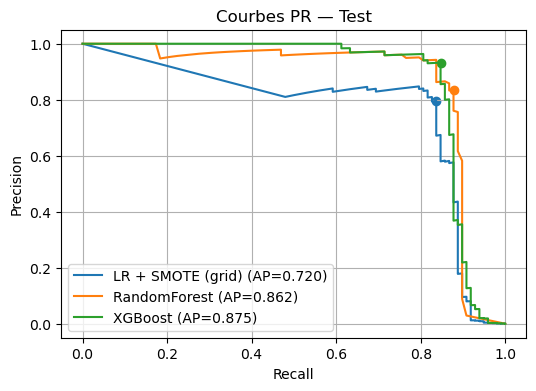

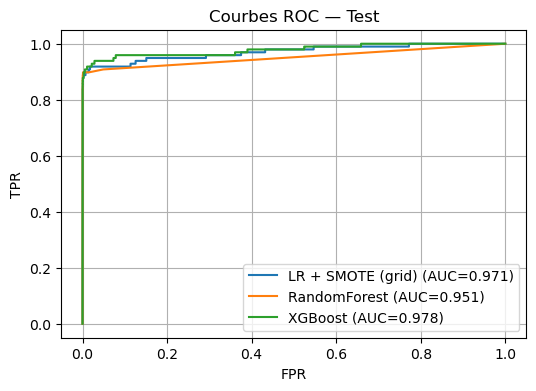

In [66]:
plot_pr_curves(pr_curves, title="Courbes PR — Test")
plot_roc_curves(roc_curves, title="Courbes ROC — Test")

## 8-) Tableau comparatif des modèles (Test)

In [67]:
# Consolidation en DataFrame
rows = []
for k, v in results.items():
    rows.append({
        "model": k,
        "pr_auc": v["pr_auc"],
        "roc_auc": v["roc_auc"],
        "threshold": v["threshold"],
        "precision": v["precision"],
        "recall": v["recall"],
        "f1": v["f1"]
    })
df_cmp = pd.DataFrame(rows).sort_values(by=["pr_auc","recall"], ascending=False).reset_index(drop=True)
df_cmp

,model,pr_auc,roc_auc,threshold,precision,recall,f1
0,XGBoost,0.874692,0.977961,0.383311,0.932584,0.846939,0.887701
1,RandomForest,0.862275,0.951454,0.170000,0.834951,0.877551,0.855721
2,LR + SMOTE (grid),0.719682,0.970762,0.999998,0.796117,0.836735,0.815920


## 9-) Sélection du meilleur modèle test et rapport détaillé

In [68]:
best_idx = df_cmp["pr_auc"].idxmax()
best_name = df_cmp.loc[best_idx, "model"]
best_name, df_cmp.loc[best_idx]

('XGBoost',
 model         XGBoost
 pr_auc       0.874692
 roc_auc      0.977961
 threshold    0.383311
 precision    0.932584
 recall       0.846939
 f1           0.887701
 Name: 0, dtype: object)

Meilleur modèle (selon PR-AUC test): XGBoost
{
  "pr_auc": 0.8747,
  "roc_auc": 0.978,
  "threshold": 0.3833,
  "precision": 0.9326,
  "recall": 0.8469,
  "f1": 0.8877
}


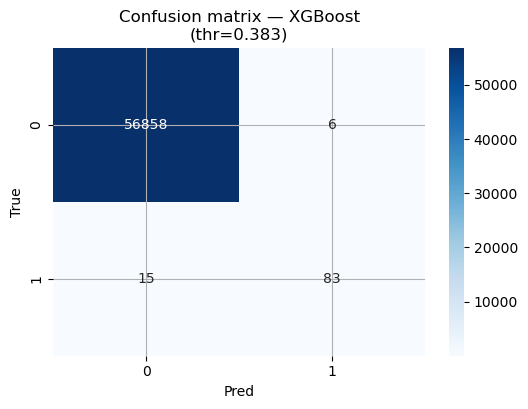

In [69]:
# Affichage détaillé du meilleur modèle (matrice et rapport)
res = results[best_name]
print("Meilleur modèle (selon PR-AUC test):", best_name)
print(json.dumps({k: (round(v,4) if isinstance(v,float) else v) for k,v in res.items() if k!="confusion_matrix"}, indent=2))

cm = np.array(res["confusion_matrix"])  #  [[TN FP], [FN TP]]
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion matrix — {best_name}\n(thr={res['threshold']:.3f})")
plt.xlabel("Pred"); plt.ylabel("True"); plt.show()

## 10-) Sauvegarde des artefacts (figures et métriques)

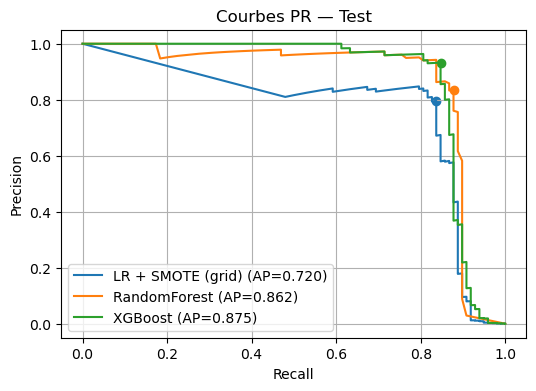

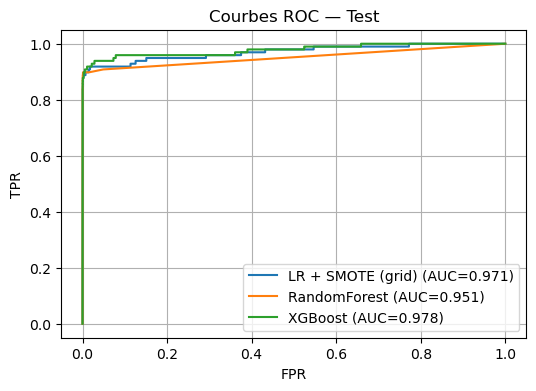

Artefacts sauvegardés dans reports/ (figures & metrics.json)


In [71]:
os.makedirs("reports/figures", exist_ok=True)
# Sauvegarde PR & ROC (retrace pour fichiers)
plot_pr_curves(pr_curves, title="Courbes PR — Test")
plt.savefig("reports/figures/pr_curves_test.png", dpi=200, bbox_inches="tight") ; plt.close()

plot_roc_curves(roc_curves, title="Courbes ROC — Test")
plt.savefig("reports/figures/roc_curves_test.png", dpi=200, bbox_inches="tight") ; plt.close()

# Sauvegarde métriques
with open("reports/metrics.json","w") as f:
    json.dump(results, f, indent=2)
print("Artefacts sauvegardés dans reports/ (figures & metrics.json)")

## 11-) Notes méthodologiques (important)

- **Perte/erreur optimisée (modèle)** : la régression logistique ajuste les paramètres en **minimisant la log-loss** (log-vraisemblance négative) via un **algorithme de type gradient/quasi-Newton** (`lbfgs`/`liblinear`).  
- **Sélection d'hyperparamètres** : `GridSearchCV` maximise le **PR-AUC (Average Precision)** en **CV stratifiée** afin d'être robuste au déséquilibre.  
- **Rééchantillonnage** : **SMOTE appliqué uniquement sur les folds d'entraînement** grâce au `Pipeline`.  
- **Seuil** : fixé sur **TEST** via **F-β (β=2)** pour privilégier le rappel, puis utilisé pour le reporting (précision/rappel/F1 + matrice de confusion).  
- **Interprétation** : si besoin, compléter par SHAP/feature importance (arbres) pour l'explicabilité.